In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv("../data/data_csv.csv")

In [3]:
df["Year"] = pd.DatetimeIndex(df['Date']).year 

In [4]:
vif = pd.DataFrame()
df_vif = df.drop("Date", axis=1)
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)
print("\nIf VIF value is higher than 10, it is usually considered having high correlation with other independent variables.")

               features  vif_Factor
0                 SP500  381.962424
1              Dividend  288.972458
2              Earnings  144.001576
3  Consumer Price Index   40.233282
4    Long Interest Rate   11.172129
5            Real Price  386.726001
6         Real Dividend  293.661481
7         Real Earnings  163.017104
8                  PE10   48.355051
9                  Year   68.838492

If VIF value is higher than 10, it is usually considered having high correlation with other independent variables.


"Variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. Mathematically, the VIF for a regression model variable is equal to the ratio of the overall model variance to the variance of a model that includes only that single independent variable. This ratio is calculated for each independent variable. A high VIF indicates that the associated independent variable is highly collinear with the other variables in the model."

(array([904., 302., 167.,  27.,  45.,  87.,  42.,  44.,  18.,   8.]),
 array([  87.63,  348.88,  610.13,  871.38, 1132.63, 1393.88, 1655.13,
        1916.38, 2177.63, 2438.88, 2700.13]),
 <a list of 10 Patch objects>)

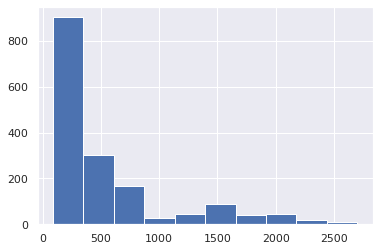

In [5]:
plt.hist(df["Real Price"])

(array([565., 320., 319., 231.,  89.,  39.,  29.,  14.,  12.,  26.]),
 array([ 6.22 , 10.557, 14.894, 19.231, 23.568, 27.905, 32.242, 36.579,
        40.916, 45.253, 49.59 ]),
 <a list of 10 Patch objects>)

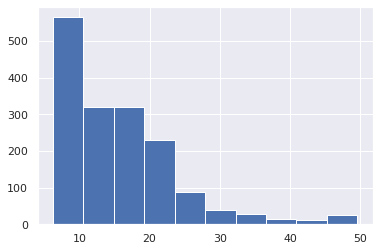

In [6]:
plt.hist(df["Real Dividend"])

(array([ 48., 313., 366., 172., 201., 176., 104.,  59., 135.,  70.]),
 array([4.47312341, 4.81591658, 5.15870976, 5.50150294, 5.84429612,
        6.1870893 , 6.52988248, 6.87267566, 7.21546884, 7.55826202,
        7.9010552 ]),
 <a list of 10 Patch objects>)

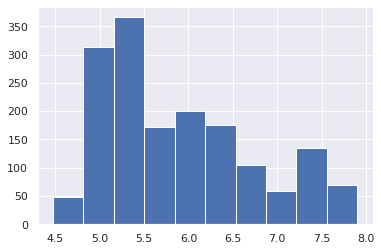

In [7]:
from scipy.stats import boxcox

data = boxcox(df["Real Price"], 0)
plt.hist(data)

### To calculate real returns we use the formula:
return[t] = return[t-1] * (((Real Price[t] - Real Price[t-1]) / Real Price[t-1])) + 1) + (Real Dividend[t-1]/RealPrice[t-1])

In [8]:
def calculate_real_return(start_year, end_year, previous_return, df_s):
    df_new_s = df_s[(df_s["Year"] >= start_year) & (df_s["Year"] < end_year)].reset_index(drop=True)
    
    diff_price = ((df_new_s["Real Price"].values[-1] - df_new_s["Real Price"].values[0]) / (df_new_s["Real Price"].values[0])) + 1
    cum_return = previous_return * diff_price
    reinvested_dividens = cum_return + (df_new_s["Real Dividend"].values[0] / df_new_s["Real Price"].values[0])

    return reinvested_dividens

In [9]:
start_y = 1950
end_y = 2018

previous_real_returns = []
previous_real_returns.append(1) # start with investing one dollar at the begining
i = 0

for y in range(start_y, end_y):
    real_return = calculate_real_return(y, y+1, previous_real_returns[i], df) 
    previous_real_returns.append(real_return)
    i += 1

In [10]:
len(previous_real_returns)

69

In [11]:
return_val = []
year = start_y
i = 0
year_count = []

df_new = df[df.Year>=start_y].reset_index(drop=True)

for idx, row in df_new.iterrows():
    if row.Year == year:
        return_val.append(previous_real_returns[i])
        year_count.append(i)
    else:
        year += 1
        i += 1
        return_val.append(previous_real_returns[i])
        year_count.append(i)

In [12]:
df_new = df_new.drop("Date", axis=1)
df_new["Return"] = return_val
df_new["InvestedYears"] = year_count
df_new = df_new.drop("Year", axis=1)

In [13]:
df_new.head()

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,Return,InvestedYears
0,16.88,1.15,2.34,23.5,2.32,179.46,12.23,24.84,10.75,1.0,0
1,17.21,1.16,2.35,23.5,2.34,182.96,12.33,25.02,10.91,1.0,0
2,17.35,1.17,2.37,23.6,2.36,183.67,12.39,25.09,10.91,1.0,0
3,17.84,1.18,2.43,23.6,2.38,188.86,12.49,25.69,11.18,1.0,0
4,18.44,1.19,2.48,23.7,2.40,194.39,12.54,26.18,11.46,1.0,0


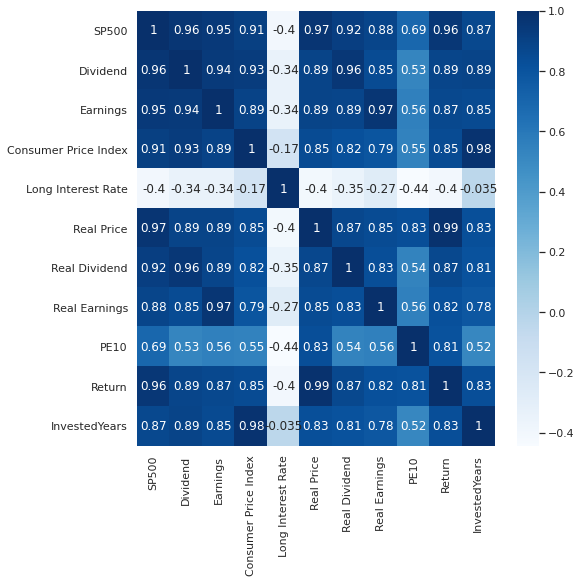

select those independent variables with high correlation with dependent variable


In [14]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_new.corr(), annot=True, cmap=plt.cm.Blues)
plt.show()

print("select those independent variables with high correlation with dependent variable")

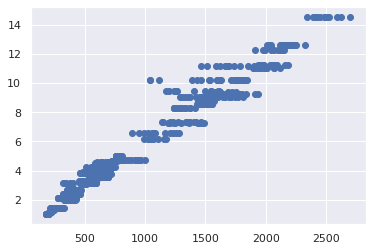

In [15]:
plt.scatter(df_new["Real Price"], df_new["Return"])

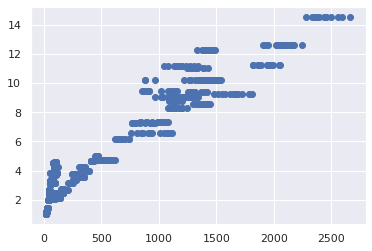

In [16]:
plt.scatter(df_new["SP500"], df_new["Return"])

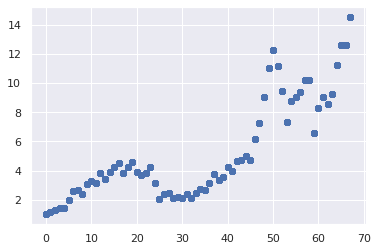

In [17]:
plt.scatter(df_new["InvestedYears"], df_new["Return"])

In [18]:
vif = pd.DataFrame()
df_vif = df_new[["SP500", "Real Price"]]
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)
print("\nIf VIF value is higher than 10, it is usually considered having high correlation with other independent variables.")

     features  vif_Factor
0       SP500   10.582163
1  Real Price   10.582163

If VIF value is higher than 10, it is usually considered having high correlation with other independent variables.


In [19]:
X = df_new[["SP500", "InvestedYears", "Real Price"]]
y = df_new[["Return"]]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [21]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     6628.
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:38:16   Log-Likelihood:                -544.38
No. Observations:                 612   AIC:                             1097.
Df Residuals:                     608   BIC:                             1114.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0838      0.091      0.918      0.359      -0.095       0.263
SP500            -0.0003      0.000     -1.464      0.144      -0.001    8.98e-05
InvestedYears     0.0109      0.002      4.403      0.000       0.006       0.016
Real Price        0.0057      0.000     33.498      0.000       0.005       0.006
==============================================================================
Omnibus:                      262.226   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2334.251
Skew:                           1.664   Prob(JB):                         0.00
Kurtosis:                      11.970   Cond. No.                     5.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
print(model.pvalues)

const             3.588462e-01
SP500             1.436013e-01
InvestedYears     1.260551e-05
Real Price       3.446177e-140
dtype: float64


In [23]:
lr = LinearRegression().fit(X_train, y_train)

In [24]:
def get_cv_scores(model):
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [25]:
get_cv_scores(lr)

CV Mean:  0.9689730071470726
STD:  0.013411020074040375




In [26]:
y_pred = lr.predict(X_test)

In [27]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Mean squared error: 0.28
Coefficient of determination: 0.98


## Using PCA to transform features

In [28]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [30]:
def transform_features(num_components):
    scaler = MinMaxScaler()
    X_train_minmax = scaler.fit_transform(X_train)
    X_test_minmax = scaler.transform(X_test)
    
    pca = PCA(n_components=num_components)
    X_train_pca = pca.fit_transform(X_train_minmax)
    X_test_pca = pca.transform(X_test_minmax)
    return pca, X_train_pca, X_test_pca

In [31]:
pca, X_train_pca, X_test_pca = transform_features(0.99)

In [32]:
lr = LinearRegression().fit(X_train_pca, y_train)

In [33]:
y_pred = lr.predict(X_test_pca)

In [34]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 0.42
Coefficient of determination: 0.96


In [35]:
X_train_sm = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     3188.
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:38:16   Log-Likelihood:                -608.88
No. Observations:                 612   AIC:                             1230.
Df Residuals:                     606   BIC:                             1256.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2715      0.027    198.304      0.000       5.219       5.324
x1             4.4861      0.037    120.649      0.000       4.413       4.559
x2            -2.6223      0.110    -23.919      0.000      -2.838      -2.407
x3             4.2507      0.167     25.465      0.000       3.923       4.579
x4            -0.6643      0.204     -3.260      0.001      -1.064      -0.264
x5             3.3523      0.273     12.267      0.000       2.816       3.889
==============================================================================
Omnibus:                       95.331   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              246.005
Skew:                           0.796   Prob(JB):                     3.81e-54
Kurtosis:                       5.667   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
cv = cross_val_score( LinearRegression(), X_train_pca, y_train, cv=10)
print(f"Mean cross-validation score: {cv.mean():.4f}")

Mean cross-validation score: 0.9608


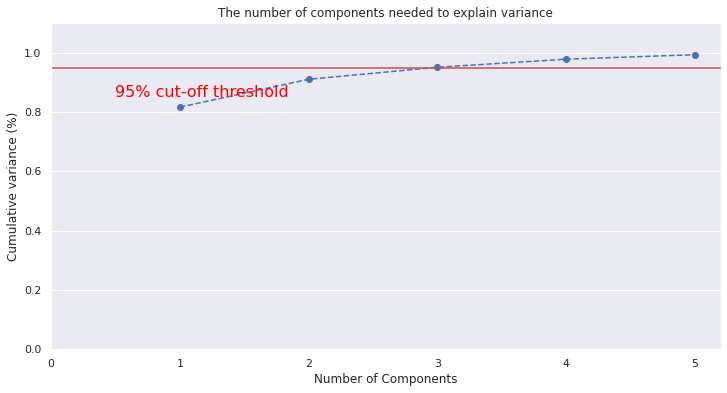

In [37]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
end_d = 6 if start_y != 2000 else 5
xi = np.arange(1, end_d, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, end_d, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [38]:
pca, X_train_pca, X_test_pca = transform_features(3) # try with 3 components

In [39]:
X_train_sm = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     4168.
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:38:16   Log-Likelihood:                -681.02
No. Observations:                 612   AIC:                             1370.
Df Residuals:                     608   BIC:                             1388.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2715      0.030    176.544      0.000       5.213       5.330
x1             4.4861      0.042    107.410      0.000       4.404       4.568
x2            -2.6223      0.123    -21.295      0.000      -2.864      -2.380
x3             4.2507      0.188     22.670      0.000       3.882       4.619
==============================================================================
Omnibus:                       46.152   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.055
Skew:                           0.519   Prob(JB):                     1.12e-17
Kurtosis:                       4.409   Cond. No.                         6.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
lr = LinearRegression().fit(X_train_pca, y_train)
y_pred = lr.predict(X_test_pca)

In [41]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

cv = cross_val_score(LinearRegression(), X_train_pca, y_train, cv=10)
print(f"Mean cross-validation score: {cv.mean():.4f}")

Mean squared error: 0.52
Coefficient of determination: 0.96
Mean cross-validation score: 0.9514


In [42]:
y_pred.tolist()
y_pred_list = [i[0] for i in y_pred.tolist()]

Text(0, 0.5, 'Return')

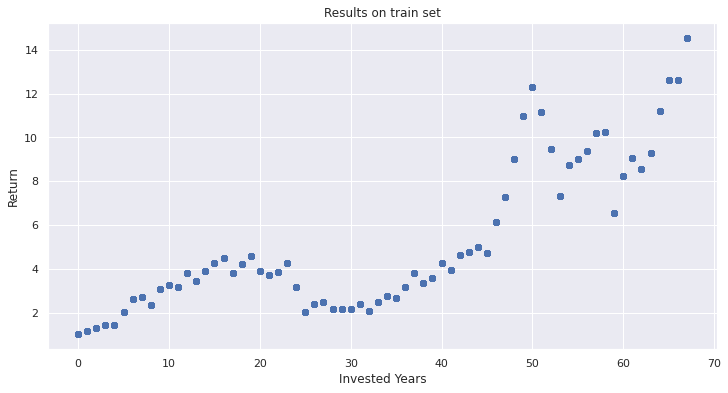

In [43]:
plt.scatter(list(X_train["InvestedYears"]), list(y_train.Return))
plt.title("Results on train set")
plt.xlabel("Invested Years")
plt.ylabel("Return")

Text(0, 0.5, 'Return')

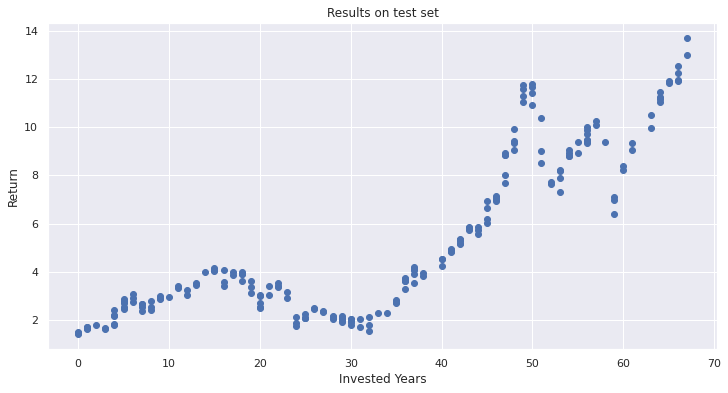

In [44]:
plt.scatter(list(X_test["InvestedYears"]), y_pred_list)
plt.title("Results on test set")
plt.xlabel("Invested Years")
plt.ylabel("Return")

In [45]:
updated_df = pd.read_csv("../data/U.S. Stock Markets 1871-Present.csv")

In [46]:
years = []
for idx, row in updated_df.iterrows():
    years.append(int(str(row["Date"]).split('.')[0]))

In [47]:
updated_df["Year"] = years

In [48]:
# we don't have whole year in 2020 so we exclude 2020
start_y = 2018
end_y = 2020
updated_df = updated_df[(updated_df["Year"] >= start_y) & (updated_df["Year"] < end_y)].reset_index(drop=True)

updated_df.drop("Date", axis=1, inplace=True)
updated_df = updated_df.drop(["RealTRScaledEarnings", "Real Total Return Price"], axis=1)

In [49]:
updated_df

,S&PComp,Dividend,Earnings,ConsumerPriceIndexCPI,Long Interest Rate GS10,Real Price,Real Dividend,Real Earnings,Year
0,2789.80,49.29,111.73,247.87,2.58,2923.58,51.65,117.09,2018
1,2705.16,49.64,113.59,248.99,2.86,2822.08,51.79,118.50,2018
2,2702.77,50.00,115.44,249.55,2.84,2813.23,52.04,120.16,2018
3,2653.63,50.33,117.79,250.55,2.87,2751.14,52.18,122.12,2018
4,2701.49,50.66,120.13,251.59,2.98,2789.16,52.30,124.03,2018
5,2754.35,50.99,122.48,251.99,2.91,2839.21,52.56,126.25,2018
6,2793.64,51.44,125.12,252.01,2.89,2879.52,53.02,128.96,2018
7,2857.82,51.89,127.75,252.15,2.89,2944.04,53.46,131.61,2018
8,2901.50,52.34,130.39,252.44,3.00,2985.57,53.86,134.17,2018
9,2785.46,52.81,131.06,252.89,3.15,2861.11,54.24,134.62,2018


In [50]:
previous_real_returns = []
previous_real_returns.append(1) # start with investing one dollar at the begining
i = 0

for y in range(start_y, end_y):
    real_return = calculate_real_return(y, y+1, previous_real_returns[i], updated_df) 
    previous_real_returns.append(real_return)
    i += 1

In [51]:
return_val = []
year = start_y
i = 0
year_count = []

for idx, row in updated_df.iterrows():
    if row.Year == year:
        return_val.append(previous_real_returns[i])
        year_count.append(i)
    else:
        year += 1
        i += 1
        return_val.append(previous_real_returns[i])
        year_count.append(i)

In [52]:
updated_df["Return"] = return_val
updated_df["InvestedYears"] = year_count
updated_df = updated_df.drop("Year", axis=1)

In [53]:
y = updated_df[["Return"]]
X = updated_df.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [54]:
pca, X_train_pca, X_test_pca = transform_features(3) # try with 3 components

In [55]:
y_pred = lr.predict(X_test_pca)

In [56]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 71.57
Coefficient of determination: -93049.91
